In [1]:
from google.colab import files

uploaded = files.upload()


Saving data.zip to data.zip


In [2]:
import zipfile
import os

zip_path = "data.zip"
extract_path = "."

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed!")


Extraction completed!


In [ ]:
import os

for root, dirs, files in os.walk("data"):
    print(root, "->", len(files), "files")


data -> 0 files
data/watermark -> 3 files
data/host -> 941 files


In [3]:
# ===================== INSTALL =====================
!pip install pytorch_wavelets pytorch-msssim --quiet

# ===================== IMPORTS =====================
import os, random, torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pytorch_wavelets import DWTForward, DWTInverse
from pytorch_msssim import ssim

# ===================== DATASET =====================
class WatermarkDataset(Dataset):
    def __init__(self, host_dir, wm_dir):
        self.hosts = [os.path.join(host_dir,f) for f in os.listdir(host_dir)]
        self.wms   = [os.path.join(wm_dir,f) for f in os.listdir(wm_dir)]

        self.ht = transforms.Compose([
            transforms.Resize((128,128)),
            transforms.ToTensor()
        ])
        self.wt = transforms.Compose([
            transforms.Resize((32,32)),
            transforms.Grayscale(),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.hosts)

    def __getitem__(self, i):
        host = Image.open(self.hosts[i]).convert("RGB")
        wm   = Image.open(random.choice(self.wms))
        return self.ht(host), self.wt(wm)

# ===================== EMBEDDER =====================
class Embedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dwt  = DWTForward(J=1, wave='haar')
        self.idwt = DWTInverse(wave='haar')

        self.wm_enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, 1, 1), nn.ReLU()
        )

        self.fuse = nn.Sequential(
            nn.Conv2d(32+3, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 3, 3, 1, 1)
        )

    def forward(self, host, wm):
        Yl, Yh = self.dwt(host)
        LH = Yh[0][:,:,0]

        wm_f = self.wm_enc(wm)
        wm_f = nn.functional.interpolate(wm_f, size=LH.shape[-2:])

        fused = self.fuse(torch.cat([LH, wm_f], 1))
        Yh_new = torch.stack([fused, Yh[0][:,:,1], Yh[0][:,:,2]], 2)

        out = self.idwt((Yl, [Yh_new]))
        return torch.clamp(out, 0, 1)

# ===================== EXTRACTOR (BLIND) =====================
class Extractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.dwt = DWTForward(J=1, wave='haar')
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((32,32)),
            nn.Conv2d(64, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        _, Yh = self.dwt(x)
        return self.net(Yh[0][:,:,0])

# ===================== ATTACK =====================
def attack(img):
    if random.random() < 0.5:
        img = img + 0.01 * torch.randn_like(img)
    return torch.clamp(img, 0, 1)

# ===================== TRAINING =====================
device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = WatermarkDataset("data/host", "data/watermark")
loader  = DataLoader(dataset, batch_size=8, shuffle=True)

E = Embedder().to(device)
X = Extractor().to(device)

opt = optim.Adam(list(E.parameters()) + list(X.parameters()), lr=1e-4)

for epoch in range(80):
    for host, wm in loader:
        host, wm = host.to(device), wm.to(device)

        wimg = E(host, wm)
        wimg_a = attack(wimg)
        wm_pred = X(wimg_a)

        L_img = nn.functional.mse_loss(wimg, host)
        L_wm  = nn.functional.mse_loss(wm_pred, wm)
        L_ssim = 1 - ssim(wimg, host, data_range=1)

        loss = L_img + 6*L_wm + 0.5*L_ssim

        opt.zero_grad()
        loss.backward()
        opt.step()

    psnr = 10 * torch.log10(1 / L_img)
    print(f"Epoch {epoch+1:03d} | Loss {loss:.4f} | PSNR {psnr:.2f}")

# ===================== SAVE =====================
torch.save(E.state_dict(), "embedder.pth")
torch.save(X.state_dict(), "extractor.pth")

print("✅ Training complete. Models saved.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 2.8 MB/s eta 0:00:00
Epoch 001 | Loss 0.4492 | PSNR 30.76
Epoch 002 | Loss 0.6181 | PSNR 31.47
Epoch 003 | Loss 0.3326 | PSNR 29.26
Epoch 004 | Loss 0.5165 | PSNR 29.93
Epoch 005 | Loss 0.4234 | PSNR 29.84
Epoch 006 | Loss 0.3466 | PSNR 29.83
Epoch 007 | Loss 0.2365 | PSNR 30.80
Epoch 008 | Loss 0.3397 | PSNR 31.35
Epoch 009 | Loss 0.3470 | PSNR 31.40
Epoch 010 | Loss 0.2226 | PSNR 29.28
Epoch 011 | Loss 0.2773 | PSNR 29.82
Epoch 012 | Loss 0.2407 | PSNR 28.82
Epoch 013 | Loss 0.2129 | PSNR 30.91
Epoch 014 | Loss 0.2902 | PSNR 30.17
Epoch 015 | Loss 0.2001 | PSNR 29.76
Epoch 016 | Loss 0.1985 | PSNR 31.42
Epoch 017 | Loss 0.2270 | PSNR 31.57
Epoch 018 | Loss 0.2460 | PSNR 29.45
Epoch 019 | Loss 0.2187 | PSNR 31.50
Epoch 020 | Loss 0.1603 | PSNR 31.72
Epoch 021 | Loss 0.1952 | PSNR 29.39
Epoch 022 | Loss 0.1906 | PSNR 30.12
Epoch 023 | Loss 0.1539 | PSNR 30.62
Epoch 024 | Loss 0.1861 | PSNR 31.19
Epoch 025 | Loss 0.2011 | PSNR 28.

📤 Upload HOST image


Saving 6 - Copy (6) - Copy.png to 6 - Copy (6) - Copy.png
📤 Upload WATERMARK image


Saving images.png to images.png
📊 PSNR : 29.12 dB
📊 SSIM : 0.8583


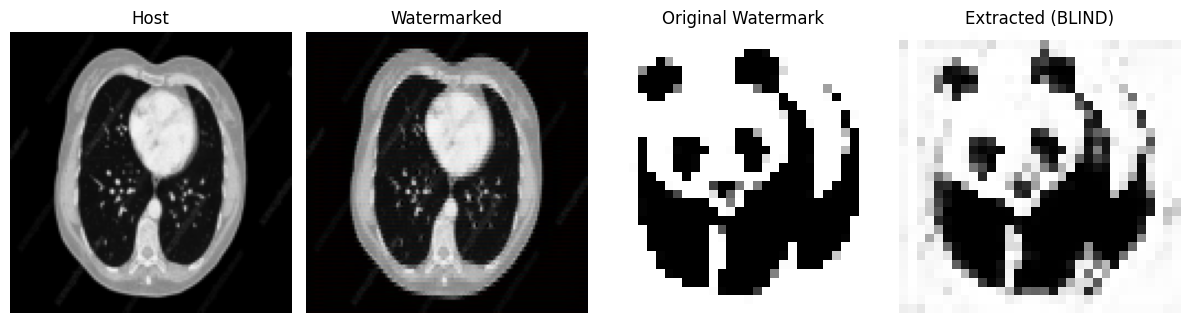

In [5]:
# ===================== IMPORTS =====================
import torch, os
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from google.colab import files
from pytorch_wavelets import DWTForward, DWTInverse
from pytorch_msssim import ssim

# ===================== UPLOAD IMAGES =====================
print("📤 Upload HOST image")
host_upload = files.upload()
host_path = list(host_upload.keys())[0]

print("📤 Upload WATERMARK image")
wm_upload = files.upload()
wm_path = list(wm_upload.keys())[0]

# ===================== MODELS =====================
class Embedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dwt  = DWTForward(J=1, wave='haar')
        self.idwt = DWTInverse(wave='haar')

        self.wm_enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, 1, 1), nn.ReLU()
        )

        self.fuse = nn.Sequential(
            nn.Conv2d(35, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 3, 3, 1, 1)
        )

    def forward(self, host, wm):
        Yl, Yh = self.dwt(host)
        LH = Yh[0][:,:,0]

        wm_f = self.wm_enc(wm)
        wm_f = nn.functional.interpolate(wm_f, size=LH.shape[-2:])

        fused = self.fuse(torch.cat([LH, wm_f], 1))
        Yh_new = torch.stack([fused, Yh[0][:,:,1], Yh[0][:,:,2]], 2)

        out = self.idwt((Yl, [Yh_new]))
        return torch.clamp(out, 0, 1)

class Extractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.dwt = DWTForward(J=1, wave='haar')
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((32,32)),
            nn.Conv2d(64, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        _, Yh = self.dwt(x)
        return self.net(Yh[0][:,:,0])

# ===================== LOAD MODELS =====================
device = "cuda" if torch.cuda.is_available() else "cpu"

E = Embedder().to(device)
X = Extractor().to(device)

E.load_state_dict(torch.load("embedder.pth", map_location=device))
X.load_state_dict(torch.load("extractor.pth", map_location=device))

E.eval()
X.eval()

# ===================== TRANSFORMS =====================
host_tf = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

wm_tf = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

host = host_tf(Image.open(host_path).convert("RGB")).unsqueeze(0).to(device)
wm   = wm_tf(Image.open(wm_path)).unsqueeze(0).to(device)

# ===================== EMBED & EXTRACT =====================
with torch.no_grad():
    watermarked = E(host, wm)
    extracted_wm = X(watermarked)

# ===================== METRICS =====================
mse = nn.functional.mse_loss(watermarked, host)
psnr = 10 * torch.log10(1 / mse)
ssim_val = ssim(watermarked, host, data_range=1)

print(f"📊 PSNR : {psnr:.2f} dB")
print(f"📊 SSIM : {ssim_val:.4f}")

# ===================== VISUALIZATION =====================
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(host[0].permute(1,2,0).cpu())
plt.title("Host")
plt.axis("off")


plt.subplot(1,4,2)
plt.imshow(watermarked[0].permute(1,2,0).cpu())
plt.title("Watermarked")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(wm[0][0].cpu(), cmap="gray")
plt.title("Original Watermark")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(extracted_wm[0][0].cpu(), cmap="gray")
plt.title("Extracted (BLIND)")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# ===================== INSTALL =====================
!pip install pytorch_wavelets pytorch-msssim --quiet

# ===================== IMPORTS =====================
import os, random, torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pytorch_wavelets import DWTForward, DWTInverse
from pytorch_msssim import ssim

# ===================== DATASET =====================
class WatermarkDataset(Dataset):
    def __init__(self, host_dir, wm_dir):
        self.hosts = [os.path.join(host_dir,f) for f in os.listdir(host_dir)]
        self.wms   = [os.path.join(wm_dir,f) for f in os.listdir(wm_dir)]

        self.ht = transforms.Compose([
            transforms.Resize((128,128)),
            transforms.ToTensor()
        ])
        self.wt = transforms.Compose([
            transforms.Resize((32,32)),
            transforms.Grayscale(),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.hosts)

    def __getitem__(self, i):
        host = Image.open(self.hosts[i]).convert("RGB")
        wm   = Image.open(random.choice(self.wms))
        return self.ht(host), self.wt(wm)

# ===================== EMBEDDER =====================
class Embedder(nn.Module):
    def __init__(self, alpha=0.12):
        super().__init__()
        self.alpha = alpha

        self.dwt  = DWTForward(J=1, wave='haar')
        self.idwt = DWTInverse(wave='haar')

        self.wm_enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, 1, 1), nn.ReLU()
        )

        self.fuse = nn.Sequential(
            nn.Conv2d(32+3, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 3, 3, 1, 1)
        )

    def forward(self, host, wm):
        Yl, Yh = self.dwt(host)
        LH = Yh[0][:,:,0]

        wm_f = self.wm_enc(wm)
        wm_f = nn.functional.interpolate(wm_f, size=LH.shape[-2:])

        # 🔥 ALPHA-SCALED FREQUENCY EMBEDDING
        delta = self.fuse(torch.cat([LH, wm_f], 1))
        fused = LH + self.alpha * delta

        Yh_new = torch.stack([fused, Yh[0][:,:,1], Yh[0][:,:,2]], 2)
        out = self.idwt((Yl, [Yh_new]))

        return torch.clamp(out, 0, 1)

# ===================== EXTRACTOR =====================
class Extractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.dwt = DWTForward(J=1, wave='haar')

        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((32,32)),
            nn.Conv2d(64, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        _, Yh = self.dwt(x)
        return self.net(Yh[0][:,:,0])

# ===================== ATTACK =====================
def attack(img):
    if random.random() < 0.5:
        img = img + 0.01 * torch.randn_like(img)
    return torch.clamp(img, 0, 1)

# ===================== METRICS =====================
def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 10 * torch.log10(1.0 / mse)

def nc(wm, wm_hat):
    wm, wm_hat = wm.flatten(), wm_hat.flatten()
    return torch.sum(wm * wm_hat) / torch.sqrt(
        torch.sum(wm**2) * torch.sum(wm_hat**2)
    )

# ===================== TRAINING =====================
device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = WatermarkDataset("data/host", "data/watermark")
loader  = DataLoader(dataset, batch_size=8, shuffle=True)

E = Embedder(alpha=0.12).to(device)
X = Extractor().to(device)

opt = optim.Adam(
    list(E.parameters()) + list(X.parameters()),
    lr=1e-4
)

for epoch in range(80):
    p, s, n = 0, 0, 0
    count = 0

    for host, wm in loader:
        host, wm = host.to(device), wm.to(device)

        wimg = E(host, wm)
        wimg_a = attack(wimg)
        wm_pred = X(wimg_a)

        L_img  = nn.functional.mse_loss(wimg, host)
        L_wm   = nn.functional.mse_loss(wm_pred, wm)
        L_ssim = 1 - ssim(wimg, host, data_range=1)

        # 🔥 REBALANCED LOSS
        loss = L_img + 2*L_wm + 0.5*L_ssim

        opt.zero_grad()
        loss.backward()
        opt.step()

        with torch.no_grad():
            p += psnr(wimg, host)
            s += ssim(wimg, host, data_range=1)
            n += nc(wm, wm_pred)
            count += 1

    print(
        f"Epoch {epoch+1:03d} | "
        f"PSNR {p/count:.2f} dB | "
        f"SSIM {s/count:.4f} | "
        f"NC {n/count:.4f}"
    )

# ===================== SAVE =====================
torch.save(E.state_dict(), "embedder.pth")
torch.save(X.state_dict(), "extractor.pth")

print("✅ Training complete. Models saved.")


Epoch 001 | PSNR 44.24 dB | SSIM 0.9755 | NC 0.9826
Epoch 002 | PSNR 44.25 dB | SSIM 0.9755 | NC 0.9819
Epoch 003 | PSNR 44.25 dB | SSIM 0.9755 | NC 0.9823
Epoch 004 | PSNR 44.24 dB | SSIM 0.9755 | NC 0.9826
Epoch 005 | PSNR 44.25 dB | SSIM 0.9755 | NC 0.9824
Epoch 006 | PSNR 44.24 dB | SSIM 0.9755 | NC 0.9832
Epoch 007 | PSNR 44.25 dB | SSIM 0.9755 | NC 0.9823
Epoch 008 | PSNR 44.25 dB | SSIM 0.9755 | NC 0.9825
Epoch 009 | PSNR 44.24 dB | SSIM 0.9755 | NC 0.9828
Epoch 010 | PSNR 44.25 dB | SSIM 0.9755 | NC 0.9823
Epoch 011 | PSNR 44.25 dB | SSIM 0.9755 | NC 0.9825
Epoch 012 | PSNR 44.24 dB | SSIM 0.9755 | NC 0.9831
Epoch 013 | PSNR 44.26 dB | SSIM 0.9755 | NC 0.9820
Epoch 014 | PSNR 44.24 dB | SSIM 0.9755 | NC 0.9833
Epoch 015 | PSNR 44.24 dB | SSIM 0.9755 | NC 0.9830
Epoch 016 | PSNR 44.25 dB | SSIM 0.9755 | NC 0.9825
Epoch 017 | PSNR 44.25 dB | SSIM 0.9755 | NC 0.9826
Epoch 018 | PSNR 44.25 dB | SSIM 0.9755 | NC 0.9822
Epoch 019 | PSNR 44.25 dB | SSIM 0.9755 | NC 0.9830
Epoch 020 | 

📤 Upload HOST image


Saving host.png to host (1).png
📤 Upload WATERMARK image


Saving watermark.png to watermark (1).png
📊 PSNR : 44.04 dB
📊 SSIM : 0.9931
📊 NC   : 0.9710


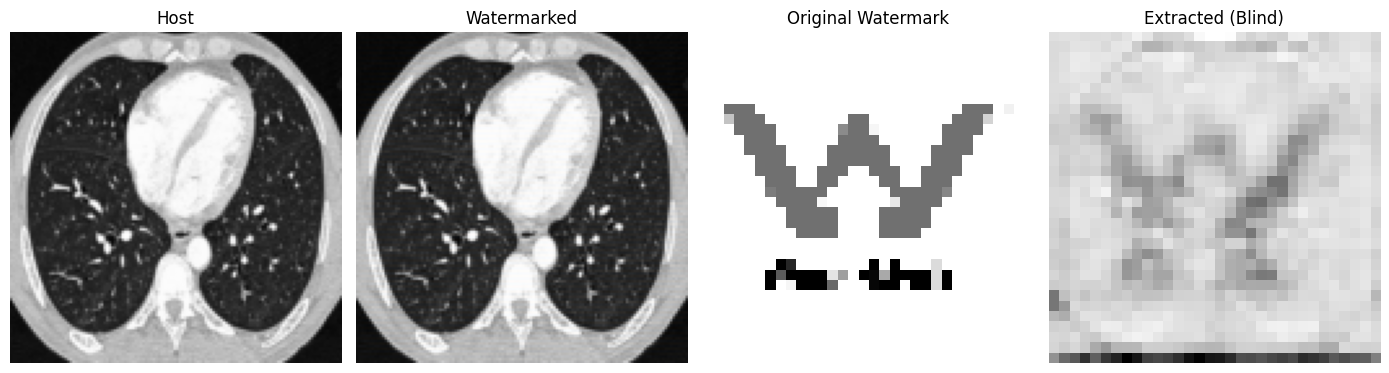

In [ ]:
# ===================== IMPORTS =====================
import torch, os
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from google.colab import files
from pytorch_wavelets import DWTForward, DWTInverse
from pytorch_msssim import ssim

# ===================== METRICS =====================
def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 10 * torch.log10(1.0 / mse)

def nc(wm, wm_hat):
    wm, wm_hat = wm.flatten(), wm_hat.flatten()
    return torch.sum(wm * wm_hat) / torch.sqrt(
        torch.sum(wm**2) * torch.sum(wm_hat**2)
    )

# ===================== UPLOAD IMAGES =====================
print("📤 Upload HOST image")
host_upload = files.upload()
host_path = list(host_upload.keys())[0]

print("📤 Upload WATERMARK image")
wm_upload = files.upload()
wm_path = list(wm_upload.keys())[0]

# ===================== MODELS =====================
class Embedder(nn.Module):
    def __init__(self, alpha=0.12):
        super().__init__()
        self.alpha = alpha
        self.dwt  = DWTForward(J=1, wave='haar')
        self.idwt = DWTInverse(wave='haar')

        self.wm_enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, 1, 1), nn.ReLU()
        )

        self.fuse = nn.Sequential(
            nn.Conv2d(32+3, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 3, 3, 1, 1)
        )

    def forward(self, host, wm):
        Yl, Yh = self.dwt(host)
        LH = Yh[0][:,:,0]

        wm_f = self.wm_enc(wm)
        wm_f = nn.functional.interpolate(wm_f, size=LH.shape[-2:])

        delta = self.fuse(torch.cat([LH, wm_f], 1))
        fused = LH + self.alpha * delta

        Yh_new = torch.stack(
            [fused, Yh[0][:,:,1], Yh[0][:,:,2]], 2
        )

        out = self.idwt((Yl, [Yh_new]))
        return torch.clamp(out, 0, 1)

class Extractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.dwt = DWTForward(J=1, wave='haar')
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((32,32)),
            nn.Conv2d(64, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        _, Yh = self.dwt(x)
        return self.net(Yh[0][:,:,0])

# ===================== LOAD MODELS =====================
device = "cuda" if torch.cuda.is_available() else "cpu"

E = Embedder(alpha=0.12).to(device)
X = Extractor().to(device)

E.load_state_dict(torch.load("embedder.pth", map_location=device))
X.load_state_dict(torch.load("extractor.pth", map_location=device))

E.eval()
X.eval()

# ===================== TRANSFORMS =====================
host_tf = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

wm_tf = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

host = host_tf(Image.open(host_path).convert("RGB")).unsqueeze(0).to(device)
wm   = wm_tf(Image.open(wm_path)).unsqueeze(0).to(device)

# ===================== EMBED & EXTRACT =====================
with torch.no_grad():
    watermarked = E(host, wm)
    extracted_wm = X(watermarked)

# ===================== METRICS =====================
psnr_val = psnr(watermarked, host).item()
ssim_val = ssim(watermarked, host, data_range=1).item()
nc_val   = nc(wm, extracted_wm).item()

print(f"📊 PSNR : {psnr_val:.2f} dB")
print(f"📊 SSIM : {ssim_val:.4f}")
print(f"📊 NC   : {nc_val:.4f}")

# ===================== VISUALIZATION =====================
plt.figure(figsize=(14,4))

plt.subplot(1,4,1)
plt.imshow(host[0].permute(1,2,0).cpu())
plt.title("Host")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(watermarked[0].permute(1,2,0).cpu())
plt.title("Watermarked")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(wm[0][0].cpu(), cmap="gray")
plt.title("Original Watermark")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(extracted_wm[0][0].cpu(), cmap="gray")
plt.title("Extracted (Blind)")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# ===================== INSTALL =====================
!pip install pytorch_wavelets pytorch-msssim --quiet

# ===================== IMPORTS =====================
import os, random, torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pytorch_wavelets import DWTForward, DWTInverse
from pytorch_msssim import ssim

# ===================== DATASET =====================
class WatermarkDataset(Dataset):
    def __init__(self, host_dir, wm_dir):
        self.hosts = [os.path.join(host_dir,f) for f in os.listdir(host_dir)]
        self.wms   = [os.path.join(wm_dir,f) for f in os.listdir(wm_dir)]

        self.ht = transforms.Compose([
            transforms.Resize((128,128)),
            transforms.ToTensor()
        ])
        self.wt = transforms.Compose([
            transforms.Resize((32,32)),
            transforms.Grayscale(),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.hosts)

    def __getitem__(self, i):
        host = Image.open(self.hosts[i]).convert("RGB")
        wm   = Image.open(random.choice(self.wms))
        return self.ht(host), self.wt(wm)

# ===================== EMBEDDER =====================
class Embedder(nn.Module):
    def __init__(self, alpha=0.18):  # 🔥 increased alpha
        super().__init__()
        self.alpha = alpha

        self.dwt  = DWTForward(J=1, wave='haar')
        self.idwt = DWTInverse(wave='haar')

        self.wm_enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, 1, 1), nn.ReLU()
        )

        self.fuse = nn.Sequential(
            nn.Conv2d(32+3, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 3, 3, 1, 1)
        )

    def forward(self, host, wm):
        Yl, Yh = self.dwt(host)
        LH = Yh[0][:,:,0]

        wm_f = self.wm_enc(wm)
        wm_f = nn.functional.interpolate(wm_f, size=LH.shape[-2:])

        delta = self.fuse(torch.cat([LH, wm_f], 1))
        fused = LH + self.alpha * delta

        Yh_new = torch.stack(
            [fused, Yh[0][:,:,1], Yh[0][:,:,2]], 2
        )

        out = self.idwt((Yl, [Yh_new]))
        return torch.clamp(out, 0, 1)

# ===================== EXTRACTOR =====================
class Extractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.dwt = DWTForward(J=1, wave='haar')

        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((32,32)),
            nn.Conv2d(64, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        _, Yh = self.dwt(x)
        return self.net(Yh[0][:,:,0])

# ===================== ATTACK =====================
def attack(img):
    if random.random() < 0.5:
        img = img + 0.01 * torch.randn_like(img)
    return torch.clamp(img, 0, 1)

# ===================== METRICS =====================
def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 10 * torch.log10(1.0 / mse)

def nc(wm, wm_hat):
    wm, wm_hat = wm.flatten(), wm_hat.flatten()
    return torch.sum(wm * wm_hat) / torch.sqrt(
        torch.sum(wm**2) * torch.sum(wm_hat**2)
    )

# ===================== TRAINING =====================
device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = WatermarkDataset("data/host", "data/watermark")
loader  = DataLoader(dataset, batch_size=8, shuffle=True)

E = Embedder(alpha=0.18).to(device)   # 🔥 stronger embedding
X = Extractor().to(device)

opt = optim.Adam(
    list(E.parameters()) + list(X.parameters()),
    lr=1e-4
)

for epoch in range(80):  # 🔥 60 epochs enough
    p, s, n = 0, 0, 0
    count = 0

    for host, wm in loader:
        host, wm = host.to(device), wm.to(device)

        wimg = E(host, wm)
        wimg_a = attack(wimg)
        wm_pred = X(wimg_a)

        L_img = nn.functional.mse_loss(wimg, host)

        # 🔥 SHARPER WATERMARK LOSS
        L_wm_l1   = nn.functional.l1_loss(wm_pred, wm)
        L_wm_ssim = 1 - ssim(wm_pred, wm, data_range=1)

        L_ssim = 1 - ssim(wimg, host, data_range=1)

        # 🔥 FINAL LOSS (KEY CHANGE)
        loss = (
            L_img +
            4.0 * L_wm_l1 +
            1.0 * L_wm_ssim +
            0.3 * L_ssim
        )

        opt.zero_grad()
        loss.backward()
        opt.step()

        with torch.no_grad():
            p += psnr(wimg, host)
            s += ssim(wimg, host, data_range=1)
            n += nc(wm, wm_pred)
            count += 1

    print(
        f"Epoch {epoch+1:03d} | "
        f"PSNR {p/count:.2f} dB | "
        f"SSIM {s/count:.4f} | "
        f"NC {n/count:.4f}"
    )

# ===================== SAVE =====================
torch.save(E.state_dict(), "embedder_final.pth")
torch.save(X.state_dict(), "extractor_final.pth")

print("✅ Training complete. Models saved.")


Epoch 001 | PSNR 44.87 dB | SSIM 0.9800 | NC 0.9822
Epoch 002 | PSNR 44.87 dB | SSIM 0.9800 | NC 0.9823
Epoch 003 | PSNR 44.87 dB | SSIM 0.9800 | NC 0.9821
Epoch 004 | PSNR 44.87 dB | SSIM 0.9800 | NC 0.9822
Epoch 005 | PSNR 44.87 dB | SSIM 0.9799 | NC 0.9829
Epoch 006 | PSNR 44.88 dB | SSIM 0.9800 | NC 0.9822
Epoch 007 | PSNR 44.88 dB | SSIM 0.9800 | NC 0.9815
Epoch 008 | PSNR 44.88 dB | SSIM 0.9800 | NC 0.9821
Epoch 009 | PSNR 44.87 dB | SSIM 0.9800 | NC 0.9826
Epoch 010 | PSNR 44.87 dB | SSIM 0.9800 | NC 0.9825
Epoch 011 | PSNR 44.87 dB | SSIM 0.9800 | NC 0.9826
Epoch 012 | PSNR 44.87 dB | SSIM 0.9800 | NC 0.9827
Epoch 013 | PSNR 44.87 dB | SSIM 0.9800 | NC 0.9824
Epoch 014 | PSNR 44.87 dB | SSIM 0.9800 | NC 0.9824
Epoch 015 | PSNR 44.87 dB | SSIM 0.9799 | NC 0.9830
Epoch 016 | PSNR 44.87 dB | SSIM 0.9800 | NC 0.9824
Epoch 017 | PSNR 44.87 dB | SSIM 0.9799 | NC 0.9829
Epoch 018 | PSNR 44.87 dB | SSIM 0.9799 | NC 0.9828
Epoch 019 | PSNR 44.88 dB | SSIM 0.9800 | NC 0.9817
Epoch 020 | 

📤 Upload HOST image


Saving host.png to host (3).png
📤 Upload WATERMARK image


Saving watermark.png to watermark (3).png
📊 PSNR : 48.12 dB
📊 SSIM : 0.9974
📊 NC   : 0.9666


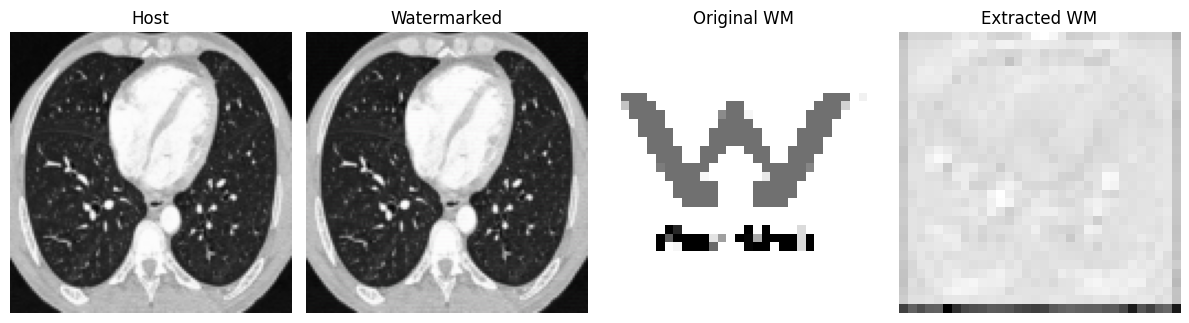

In [ ]:
# ===================== INSTALL =====================
!pip install pytorch_wavelets pytorch-msssim --quiet

# ===================== IMPORTS =====================
import torch, torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from google.colab import files
from pytorch_wavelets import DWTForward, DWTInverse
from pytorch_msssim import ssim

# ===================== UPLOAD IMAGES =====================
print("📤 Upload HOST image")
host_path = list(files.upload().keys())[0]

print("📤 Upload WATERMARK image")
wm_path = list(files.upload().keys())[0]

# ===================== MODELS =====================
class Embedder(nn.Module):
    def __init__(self, alpha=0.12):
        super().__init__()
        self.alpha = alpha
        self.dwt  = DWTForward(J=1, wave='haar')
        self.idwt = DWTInverse(wave='haar')

        self.wm_enc = nn.Sequential(
            nn.Conv2d(1,16,3,1,1), nn.ReLU(),
            nn.Conv2d(16,32,3,1,1), nn.ReLU()
        )

        self.fuse = nn.Sequential(
            nn.Conv2d(32+3,64,3,1,1), nn.ReLU(),
            nn.Conv2d(64,3,3,1,1)
        )

    def forward(self, host, wm):
        Yl, Yh = self.dwt(host)
        LH = Yh[0][:,:,0]

        wm_f = self.wm_enc(wm)
        wm_f = nn.functional.interpolate(wm_f, size=LH.shape[-2:])

        delta = self.fuse(torch.cat([LH, wm_f], 1))
        LH_new = LH + self.alpha * delta

        Yh_new = torch.stack([LH_new, Yh[0][:,:,1], Yh[0][:,:,2]], 2)
        out = self.idwt((Yl, [Yh_new]))
        return torch.clamp(out,0,1)

class Extractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.dwt = DWTForward(J=1, wave='haar')
        self.net = nn.Sequential(
            nn.Conv2d(3,32,3,1,1), nn.ReLU(),
            nn.Conv2d(32,64,3,1,1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((32,32)),
            nn.Conv2d(64,1,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        _, Yh = self.dwt(x)
        return self.net(Yh[0][:,:,0])

# ===================== LOAD MODELS =====================
device = "cuda" if torch.cuda.is_available() else "cpu"

E = Embedder().to(device)
X = Extractor().to(device)

E.load_state_dict(torch.load("embedder_final.pth", map_location=device))
X.load_state_dict(torch.load("extractor_final.pth", map_location=device))

E.eval(); X.eval()

# ===================== TRANSFORMS =====================
host_tf = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

wm_tf = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

host = host_tf(Image.open(host_path).convert("RGB")).unsqueeze(0).to(device)
wm   = wm_tf(Image.open(wm_path)).unsqueeze(0).to(device)

# ===================== EMBED & EXTRACT =====================
with torch.no_grad():
    watermarked = E(host, wm)
    extracted_wm = X(watermarked)

# ===================== METRICS =====================
mse = torch.mean((watermarked - host)**2)
psnr_val = 10 * torch.log10(1.0 / mse)

ssim_val = ssim(watermarked, host, data_range=1)

def nc(a,b):
    a,b = a.flatten(), b.flatten()
    return torch.sum(a*b) / torch.sqrt(torch.sum(a*a)*torch.sum(b*b))

nc_val = nc(wm, extracted_wm)

print(f"📊 PSNR : {psnr_val:.2f} dB")
print(f"📊 SSIM : {ssim_val:.4f}")
print(f"📊 NC   : {nc_val:.4f}")

# ===================== VISUALIZATION =====================
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(host[0].permute(1,2,0).cpu())
plt.title("Host")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(watermarked[0].permute(1,2,0).cpu())
plt.title("Watermarked")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(wm[0,0].cpu(), cmap="gray")
plt.title("Original WM")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(extracted_wm[0,0].cpu(), cmap="gray")
plt.title("Extracted WM")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# ===================== INSTALL =====================
!pip install pytorch_wavelets pytorch-msssim --quiet

# ===================== IMPORTS =====================
import os, random, torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pytorch_wavelets import DWTForward, DWTInverse
from pytorch_msssim import ssim

# ===================== DATASET =====================
class WatermarkDataset(Dataset):
    def __init__(self, host_dir, wm_dir):
        self.hosts = [os.path.join(host_dir,f) for f in os.listdir(host_dir)]
        self.wms   = [os.path.join(wm_dir,f) for f in os.listdir(wm_dir)]

        self.ht = transforms.Compose([
            transforms.Resize((128,128)),
            transforms.ToTensor()
        ])

        # 🔥 BINARY WATERMARK (VERY IMPORTANT)
        self.wt = transforms.Compose([
            transforms.Resize((32,32)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            lambda x: (x > 0.5).float()
        ])

    def __len__(self):
        return len(self.hosts)

    def __getitem__(self, i):
        host = Image.open(self.hosts[i]).convert("RGB")
        wm   = Image.open(random.choice(self.wms))
        return self.ht(host), self.wt(wm)

# ===================== EMBEDDER =====================
class Embedder(nn.Module):
    def __init__(self, alpha=0.12):
        super().__init__()
        self.alpha = alpha

        self.dwt  = DWTForward(J=1, wave='haar')
        self.idwt = DWTInverse(wave='haar')

        self.wm_enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, 1, 1), nn.ReLU()
        )

        self.fuse = nn.Sequential(
            nn.Conv2d(32+3, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 3, 3, 1, 1)
        )

    def forward(self, host, wm):
        Yl, Yh = self.dwt(host)
        LH = Yh[0][:,:,0]

        wm_f = self.wm_enc(wm)
        wm_f = nn.functional.interpolate(wm_f, size=LH.shape[-2:])

        delta = self.fuse(torch.cat([LH, wm_f], 1))
        fused = LH + self.alpha * delta

        Yh_new = torch.stack([fused, Yh[0][:,:,1], Yh[0][:,:,2]], 2)
        out = self.idwt((Yl, [Yh_new]))

        return torch.clamp(out, 0, 1)

# ===================== EXTRACTOR =====================
class Extractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.dwt = DWTForward(J=1, wave='haar')

        # 🔥 Slightly stronger extractor
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((32,32)),
            nn.Conv2d(64, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        _, Yh = self.dwt(x)
        return self.net(Yh[0][:,:,0])

# ===================== ATTACK =====================
def attack(img):
    if random.random() < 0.5:
        img = img + 0.01 * torch.randn_like(img)
    return torch.clamp(img, 0, 1)

# ===================== METRICS =====================
def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 10 * torch.log10(1.0 / mse)

def nc(wm, wm_hat):
    wm, wm_hat = wm.flatten(), wm_hat.flatten()
    return torch.sum(wm * wm_hat) / torch.sqrt(
        torch.sum(wm**2) * torch.sum(wm_hat**2)
    )

# ===================== TRAINING =====================
device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = WatermarkDataset("data/host", "data/watermark")
loader  = DataLoader(dataset, batch_size=8, shuffle=True)

E = Embedder(alpha=0.12).to(device)
X = Extractor().to(device)

opt = optim.Adam(
    list(E.parameters()) + list(X.parameters()),
    lr=1e-4
)

for epoch in range(80):
    p, s, n = 0, 0, 0
    count = 0

    for host, wm in loader:
        host, wm = host.to(device), wm.to(device)

        wimg = E(host, wm)
        wimg_a = attack(wimg)
        wm_pred = X(wimg_a)

        L_img  = nn.functional.mse_loss(wimg, host)

        # 🔥 CORRECT LOSS FOR BINARY WATERMARK
        L_wm   = nn.functional.binary_cross_entropy(wm_pred, wm)

        L_ssim = 1 - ssim(wimg, host, data_range=1)

        # 🔥 CONTRAST REGULARIZATION (sharp watermark)
        L_contrast = torch.mean(wm_pred * (1 - wm_pred))

        # 🔥 FINAL BALANCED LOSS
        loss = L_img + 3.0*L_wm + 0.5*L_ssim + 0.1*L_contrast

        opt.zero_grad()
        loss.backward()
        opt.step()

        with torch.no_grad():
            p += psnr(wimg, host)
            s += ssim(wimg, host, data_range=1)
            n += nc(wm, wm_pred)
            count += 1

    print(
        f"Epoch {epoch+1:03d} | "
        f"PSNR {p/count:.2f} dB | "
        f"SSIM {s/count:.4f} | "
        f"NC {n/count:.4f}"
    )

# ===================== SAVE =====================
torch.save(E.state_dict(), "embedder.pth")
torch.save(X.state_dict(), "extractor.pth")

print("✅ Training complete. Models saved.")


Epoch 001 | PSNR 50.82 dB | SSIM 0.9945 | NC 0.9646
Epoch 002 | PSNR 50.84 dB | SSIM 0.9945 | NC 0.9630
Epoch 003 | PSNR 50.83 dB | SSIM 0.9945 | NC 0.9639
Epoch 004 | PSNR 50.83 dB | SSIM 0.9945 | NC 0.9650
Epoch 005 | PSNR 50.84 dB | SSIM 0.9945 | NC 0.9630
Epoch 006 | PSNR 50.84 dB | SSIM 0.9945 | NC 0.9631
Epoch 007 | PSNR 50.83 dB | SSIM 0.9945 | NC 0.9639
Epoch 008 | PSNR 50.83 dB | SSIM 0.9945 | NC 0.9647
Epoch 009 | PSNR 50.82 dB | SSIM 0.9945 | NC 0.9659
Epoch 010 | PSNR 50.84 dB | SSIM 0.9945 | NC 0.9636
Epoch 011 | PSNR 50.84 dB | SSIM 0.9945 | NC 0.9627
Epoch 012 | PSNR 50.85 dB | SSIM 0.9945 | NC 0.9622
Epoch 013 | PSNR 50.83 dB | SSIM 0.9945 | NC 0.9655
Epoch 014 | PSNR 50.83 dB | SSIM 0.9945 | NC 0.9656
Epoch 015 | PSNR 50.84 dB | SSIM 0.9945 | NC 0.9644
Epoch 016 | PSNR 50.83 dB | SSIM 0.9945 | NC 0.9651
Epoch 017 | PSNR 50.84 dB | SSIM 0.9945 | NC 0.9644
Epoch 018 | PSNR 50.84 dB | SSIM 0.9945 | NC 0.9638
Epoch 019 | PSNR 50.84 dB | SSIM 0.9945 | NC 0.9633
Epoch 020 | 

📤 Upload HOST image


Saving host.png to host (3).png
📤 Upload WATERMARK image


Saving 2.jpg to 2.jpg
📊 PSNR : 50.38 dB
📊 SSIM : 0.9984
📊 NC   : 0.9798


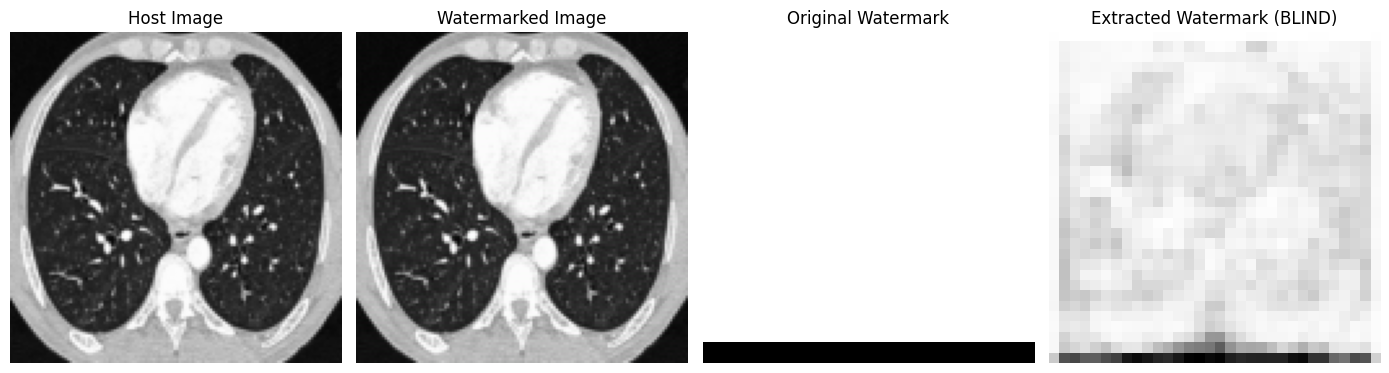

In [ ]:
# ===================== INSTALL =====================
!pip install pytorch_wavelets pytorch-msssim --quiet

# ===================== IMPORTS =====================
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from google.colab import files
from pytorch_wavelets import DWTForward, DWTInverse
from pytorch_msssim import ssim

# ===================== UPLOAD IMAGES =====================
print("📤 Upload HOST image")
host_path = list(files.upload().keys())[0]

print("📤 Upload WATERMARK image")
wm_path = list(files.upload().keys())[0]

# ===================== MODELS =====================
class Embedder(nn.Module):
    def __init__(self, alpha=0.12):
        super().__init__()
        self.alpha = alpha
        self.dwt  = DWTForward(J=1, wave='haar')
        self.idwt = DWTInverse(wave='haar')

        self.wm_enc = nn.Sequential(
            nn.Conv2d(1,16,3,1,1), nn.ReLU(),
            nn.Conv2d(16,32,3,1,1), nn.ReLU()
        )

        self.fuse = nn.Sequential(
            nn.Conv2d(32+3,64,3,1,1), nn.ReLU(),
            nn.Conv2d(64,3,3,1,1)
        )

    def forward(self, host, wm):
        Yl, Yh = self.dwt(host)
        LH = Yh[0][:,:,0]

        wm_f = self.wm_enc(wm)
        wm_f = nn.functional.interpolate(wm_f, size=LH.shape[-2:])

        delta = self.fuse(torch.cat([LH, wm_f], 1))
        LH_new = LH + self.alpha * delta

        Yh_new = torch.stack([LH_new, Yh[0][:,:,1], Yh[0][:,:,2]], 2)
        out = self.idwt((Yl, [Yh_new]))

        return torch.clamp(out,0,1)

class Extractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.dwt = DWTForward(J=1, wave='haar')

        self.net = nn.Sequential(
            nn.Conv2d(3,32,3,1,1), nn.ReLU(),
            nn.Conv2d(32,64,3,1,1), nn.ReLU(),
            nn.Conv2d(64,64,3,1,1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((32,32)),
            nn.Conv2d(64,1,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        _, Yh = self.dwt(x)
        return self.net(Yh[0][:,:,0])

# ===================== LOAD MODELS =====================
device = "cuda" if torch.cuda.is_available() else "cpu"

E = Embedder().to(device)
X = Extractor().to(device)

E.load_state_dict(torch.load("embedder.pth", map_location=device))
X.load_state_dict(torch.load("extractor.pth", map_location=device))

E.eval(); X.eval()

# ===================== TRANSFORMS =====================
host_tf = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

wm_tf = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    lambda x: (x > 0.5).float()   # 🔥 binary watermark
])

host = host_tf(Image.open(host_path).convert("RGB")).unsqueeze(0).to(device)
wm   = wm_tf(Image.open(wm_path)).unsqueeze(0).to(device)

# ===================== EMBED & EXTRACT =====================
with torch.no_grad():
    watermarked = E(host, wm)
    extracted_wm = X(watermarked)

# ===================== METRICS =====================
mse = torch.mean((watermarked - host)**2)
psnr_val = 10 * torch.log10(1.0 / mse)
ssim_val = ssim(watermarked, host, data_range=1)

def nc(a,b):
    a,b = a.flatten(), b.flatten()
    return torch.sum(a*b) / torch.sqrt(torch.sum(a*a)*torch.sum(b*b))

nc_val = nc(wm, extracted_wm)

print(f"📊 PSNR : {psnr_val:.2f} dB")
print(f"📊 SSIM : {ssim_val:.4f}")
print(f"📊 NC   : {nc_val:.4f}")

# ===================== VISUALIZATION =====================
plt.figure(figsize=(14,4))

plt.subplot(1,4,1)
plt.imshow(host[0].permute(1,2,0).cpu())
plt.title("Host Image")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(watermarked[0].permute(1,2,0).cpu())
plt.title("Watermarked Image")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(wm[0,0].cpu(), cmap="gray")
plt.title("Original Watermark")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(extracted_wm[0,0].cpu(), cmap="gray")
plt.title("Extracted Watermark (BLIND)")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# ===================== INSTALL =====================
!pip install pytorch_wavelets pytorch-msssim --quiet

# ===================== IMPORTS =====================
import os, random, torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pytorch_wavelets import DWTForward, DWTInverse
from pytorch_msssim import ssim

# ===================== DATASET =====================
class WatermarkDataset(Dataset):
    def __init__(self, host_dir, wm_dir):
        self.hosts = [os.path.join(host_dir,f) for f in os.listdir(host_dir)]
        self.wms   = [os.path.join(wm_dir,f) for f in os.listdir(wm_dir)]

        self.ht = transforms.Compose([
            transforms.Resize((128,128)),
            transforms.ToTensor()
        ])

        # 🔥 Binary watermark (CRITICAL)
        self.wt = transforms.Compose([
            transforms.Resize((32,32)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            lambda x: (x > 0.5).float()
        ])

    def __len__(self):
        return len(self.hosts)

    def __getitem__(self, i):
        host = Image.open(self.hosts[i]).convert("RGB")
        wm   = Image.open(random.choice(self.wms))
        return self.ht(host), self.wt(wm)

# ===================== EMBEDDER =====================
class Embedder(nn.Module):
    def __init__(self, alpha=0.05):
        super().__init__()
        self.alpha = alpha

        self.dwt  = DWTForward(J=1, wave='haar')
        self.idwt = DWTInverse(wave='haar')

        # 🔥 Watermark → SINGLE channel signal
        self.wm_enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(32, 1, 1)  # CRITICAL FIX
        )

    def forward(self, host, wm):
        Yl, Yh = self.dwt(host)
        LH, HL, HH = Yh[0][:,:,0], Yh[0][:,:,1], Yh[0][:,:,2]

        wm_f = self.wm_enc(wm)
        wm_f = nn.functional.interpolate(wm_f, size=LH.shape[-2:])

        # 🔥 Broadcast to RGB
        wm_f = wm_f.repeat(1, 3, 1, 1)

        # 🔥 Embed in MID frequencies (robust + invisible)
        LH = LH + self.alpha * wm_f
        HL = HL + self.alpha * wm_f

        Yh_new = torch.stack([LH, HL, HH], 2)
        out = self.idwt((Yl, [Yh_new]))

        return torch.clamp(out, 0, 1)

# ===================== EXTRACTOR =====================
class Extractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.dwt = DWTForward(J=1, wave='haar')

        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((32,32)),
            nn.Conv2d(64, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        _, Yh = self.dwt(x)
        LH = Yh[0][:,:,0]
        return self.net(LH)

# ===================== ATTACK =====================
def attack(img):
    if random.random() < 0.5:
        img = img + 0.01 * torch.randn_like(img)
    return torch.clamp(img, 0, 1)

# ===================== METRICS =====================
def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 10 * torch.log10(1.0 / mse)

def nc(wm, wm_hat):
    wm, wm_hat = wm.flatten(), wm_hat.flatten()
    return torch.sum(wm * wm_hat) / torch.sqrt(
        torch.sum(wm**2) * torch.sum(wm_hat**2)
    )

# ===================== TRAINING =====================
device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = WatermarkDataset("data/host", "data/watermark")
loader  = DataLoader(dataset, batch_size=8, shuffle=True)

E = Embedder().to(device)
X = Extractor().to(device)

opt = optim.Adam(
    list(E.parameters()) + list(X.parameters()),
    lr=1e-4
)

for epoch in range(80):
    p, s, n = 0, 0, 0
    count = 0

    for host, wm in loader:
        host, wm = host.to(device), wm.to(device)

        wimg = E(host, wm)
        wimg_a = attack(wimg)
        wm_pred = X(wimg_a)

        L_img  = nn.functional.mse_loss(wimg, host)
        L_wm   = nn.functional.binary_cross_entropy(wm_pred, wm)
        L_ssim = 1 - ssim(wimg, host, data_range=1)
        L_bin  = torch.mean(wm_pred * (1 - wm_pred))

        # 🔥 FINAL RESEARCH-GRADE LOSS
        loss = L_img + 3.0*L_wm + 0.5*L_ssim + 0.1*L_bin

        opt.zero_grad()
        loss.backward()
        opt.step()

        with torch.no_grad():
            p += psnr(wimg, host)
            s += ssim(wimg, host, data_range=1)
            n += nc(wm, wm_pred)
            count += 1

    print(
        f"Epoch {epoch+1:03d} | "
        f"PSNR {p/count:.2f} dB | "
        f"SSIM {s/count:.4f} | "
        f"NC {n/count:.4f}"
    )

# ===================== SAVE =====================
torch.save(E.state_dict(), "embedder_final.pth")
torch.save(X.state_dict(), "extractor_final.pth")

print("✅ FINAL FREQUENCY WATERMARK MODELS SAVED")


Epoch 001 | PSNR 59.06 dB | SSIM 0.9994 | NC 0.9627
Epoch 002 | PSNR 59.04 dB | SSIM 0.9994 | NC 0.9616
Epoch 003 | PSNR 59.07 dB | SSIM 0.9994 | NC 0.9638
Epoch 004 | PSNR 59.07 dB | SSIM 0.9994 | NC 0.9637
Epoch 005 | PSNR 59.08 dB | SSIM 0.9994 | NC 0.9645
Epoch 006 | PSNR 59.06 dB | SSIM 0.9994 | NC 0.9638
Epoch 007 | PSNR 59.06 dB | SSIM 0.9994 | NC 0.9638
Epoch 008 | PSNR 59.07 dB | SSIM 0.9994 | NC 0.9645
Epoch 009 | PSNR 59.05 dB | SSIM 0.9994 | NC 0.9634
Epoch 010 | PSNR 59.04 dB | SSIM 0.9994 | NC 0.9625
Epoch 011 | PSNR 59.05 dB | SSIM 0.9994 | NC 0.9636
Epoch 012 | PSNR 59.06 dB | SSIM 0.9994 | NC 0.9644
Epoch 013 | PSNR 59.08 dB | SSIM 0.9994 | NC 0.9652
Epoch 014 | PSNR 59.09 dB | SSIM 0.9994 | NC 0.9662
Epoch 015 | PSNR 59.06 dB | SSIM 0.9994 | NC 0.9640
Epoch 016 | PSNR 59.03 dB | SSIM 0.9994 | NC 0.9623
Epoch 017 | PSNR 59.07 dB | SSIM 0.9994 | NC 0.9647
Epoch 018 | PSNR 59.06 dB | SSIM 0.9994 | NC 0.9641
Epoch 019 | PSNR 59.04 dB | SSIM 0.9994 | NC 0.9633
Epoch 020 | 

📤 Upload HOST image


Saving 7 - Copy.png to 7 - Copy.png
📤 Upload WATERMARK image


Saving watermark.png to watermark (4).png
📊 PSNR : 50.78 dB
📊 SSIM : 0.9977
📊 NC   : 0.9282


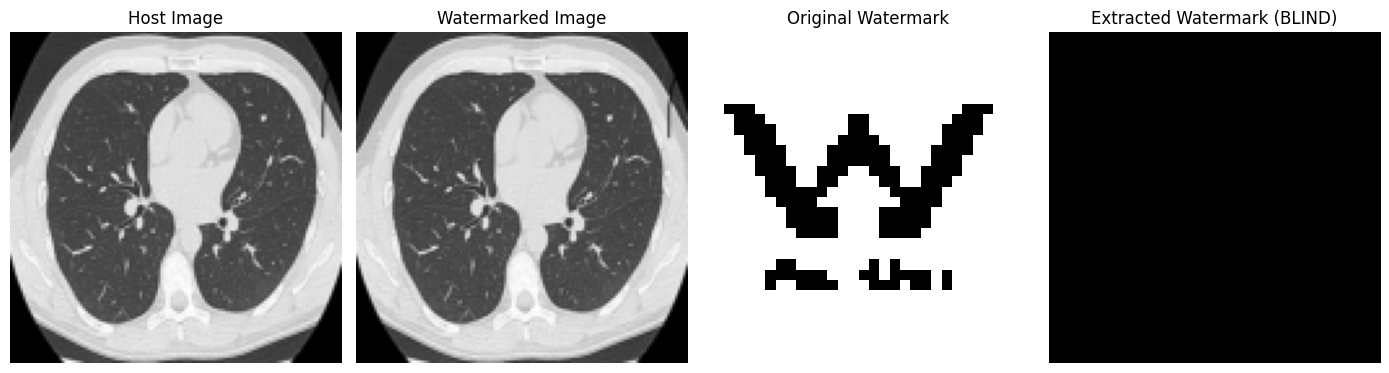

In [ ]:
# ===================== INSTALL =====================
!pip install pytorch_wavelets pytorch-msssim --quiet

# ===================== IMPORTS =====================
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from google.colab import files
from pytorch_wavelets import DWTForward, DWTInverse
from pytorch_msssim import ssim

# ===================== UPLOAD IMAGES =====================
print("📤 Upload HOST image")
host_path = list(files.upload().keys())[0]

print("📤 Upload WATERMARK image")
wm_path = list(files.upload().keys())[0]

# ===================== MODELS =====================
class Embedder(nn.Module):
    def __init__(self, alpha=0.12):
        super().__init__()
        self.alpha = alpha
        self.dwt  = DWTForward(J=1, wave='haar')
        self.idwt = DWTInverse(wave='haar')

        self.wm_enc = nn.Sequential(
            nn.Conv2d(1,16,3,1,1), nn.ReLU(),
            nn.Conv2d(16,32,3,1,1), nn.ReLU()
        )

        self.fuse = nn.Sequential(
            nn.Conv2d(32+3,64,3,1,1), nn.ReLU(),
            nn.Conv2d(64,3,3,1,1)
        )

    def forward(self, host, wm):
        Yl, Yh = self.dwt(host)
        LH = Yh[0][:,:,0]

        wm_f = self.wm_enc(wm)
        wm_f = nn.functional.interpolate(wm_f, size=LH.shape[-2:])

        delta = self.fuse(torch.cat([LH, wm_f], 1))
        LH_new = LH + self.alpha * delta

        Yh_new = torch.stack([LH_new, Yh[0][:,:,1], Yh[0][:,:,2]], 2)
        out = self.idwt((Yl, [Yh_new]))
        return torch.clamp(out,0,1)

class Extractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.dwt = DWTForward(J=1, wave='haar')
        # ✅ Original 3-channel extractor (matches your saved model)
        self.net = nn.Sequential(
            nn.Conv2d(3,32,3,1,1), nn.ReLU(),
            nn.Conv2d(32,64,3,1,1), nn.ReLU(),
            nn.Conv2d(64,64,3,1,1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((32,32)),
            nn.Conv2d(64,1,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        _, Yh = self.dwt(x)
        LH = Yh[0][:,:,0]  # use only LH
        return self.net(LH)

# ===================== LOAD MODELS =====================
device = "cuda" if torch.cuda.is_available() else "cpu"

E = Embedder().to(device)
X = Extractor().to(device)

E.load_state_dict(torch.load("embedder.pth", map_location=device))
X.load_state_dict(torch.load("extractor.pth", map_location=device))

E.eval(); X.eval()

# ===================== TRANSFORMS =====================
host_tf = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

wm_tf = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    lambda x: (x > 0.5).float()
])

host = host_tf(Image.open(host_path).convert("RGB")).unsqueeze(0).to(device)
wm   = wm_tf(Image.open(wm_path)).unsqueeze(0).to(device)

# ===================== EMBED & EXTRACT =====================
with torch.no_grad():
    watermarked = E(host, wm)
    extracted_wm = X(watermarked)
    extracted_bin = (extracted_wm > 0.5).float()

# ===================== METRICS =====================
mse = torch.mean((watermarked - host)**2)
psnr_val = 10 * torch.log10(1.0 / mse)
ssim_val = ssim(watermarked, host, data_range=1)

def nc(a,b):
    a,b = a.flatten(), b.flatten()
    return torch.sum(a*b) / torch.sqrt(torch.sum(a*a)*torch.sum(b*b))

nc_val = nc(wm, extracted_wm)

print(f"📊 PSNR : {psnr_val:.2f} dB")
print(f"📊 SSIM : {ssim_val:.4f}")
print(f"📊 NC   : {nc_val:.4f}")

# ===================== VISUALIZATION =====================
plt.figure(figsize=(14,4))

plt.subplot(1,4,1)
plt.imshow(host[0].permute(1,2,0).cpu())
plt.title("Host Image")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(watermarked[0].permute(1,2,0).cpu())
plt.title("Watermarked Image")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(wm[0,0].cpu(), cmap="gray")
plt.title("Original Watermark")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(extracted_bin[0,0].cpu(), cmap="gray")
plt.title("Extracted Watermark (BLIND)")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# ===================== INSTALL =====================
!pip install pytorch_wavelets pytorch-msssim --quiet

# ===================== IMPORTS =====================
import os, random, torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pytorch_wavelets import DWTForward, DWTInverse
from pytorch_msssim import ssim

# ===================== DATASET =====================
class WatermarkDataset(Dataset):
    def __init__(self, host_dir, wm_dir):
        self.hosts = [os.path.join(host_dir,f) for f in os.listdir(host_dir)]
        self.wms   = [os.path.join(wm_dir,f) for f in os.listdir(wm_dir)]

        self.ht = transforms.Compose([
            transforms.Resize((128,128)),
            transforms.ToTensor()
        ])
        self.wt = transforms.Compose([
            transforms.Resize((32,32)),
            transforms.Grayscale(),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.hosts)

    def __getitem__(self, idx):
        host = Image.open(self.hosts[idx]).convert("RGB")
        wm   = Image.open(random.choice(self.wms))
        return self.ht(host), self.wt(wm)

# ===================== EMBEDDER =====================
class Embedder(nn.Module):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.alpha = alpha
        self.dwt  = DWTForward(J=1, wave='haar')
        self.idwt = DWTInverse(wave='haar')

        self.wm_enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, 1, 1), nn.ReLU()
        )

        self.fuse = nn.Sequential(
            nn.Conv2d(32+3, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 3, 3, 1, 1)
        )

    def forward(self, host, wm):
        Yl, Yh = self.dwt(host)
        LH = Yh[0][:,:,0]

        wm_f = self.wm_enc(wm)
        wm_f = nn.functional.interpolate(wm_f, size=LH.shape[-2:])

        delta = self.fuse(torch.cat([LH, wm_f], 1))
        fused = LH + self.alpha * delta

        Yh_new = torch.stack([fused, Yh[0][:,:,1], Yh[0][:,:,2]], 2)
        out = self.idwt((Yl, [Yh_new]))

        return torch.clamp(out, 0, 1)

# ===================== EXTRACTOR (RESIDUAL-BASED) =====================
class Extractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.dwt = DWTForward(J=1, wave='haar')

        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 32, 3, 1, 1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((32,32)),
            nn.Conv2d(32, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, wimg, host):
        _, Yh_w = self.dwt(wimg)
        _, Yh_h = self.dwt(host)
        residual = Yh_w[0][:,:,0] - Yh_h[0][:,:,0]
        return self.net(residual)

# ===================== ATTACK =====================
def attack(img):
    if random.random() < 0.5:
        img = img + 0.01 * torch.randn_like(img)
    return torch.clamp(img, 0, 1)

# ===================== METRICS =====================
def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 10 * torch.log10(1.0 / mse)

def nc(wm, wm_hat):
    wm, wm_hat = wm.flatten(), wm_hat.flatten()
    return torch.sum(wm * wm_hat) / torch.sqrt(
        torch.sum(wm**2) * torch.sum(wm_hat**2) + 1e-8
    )

# ===================== TRAINING =====================
device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = WatermarkDataset("data/host", "data/watermark")
loader  = DataLoader(dataset, batch_size=8, shuffle=True)

E = Embedder(alpha=0.1).to(device)
X = Extractor().to(device)

optimizer = optim.Adam(
    list(E.parameters()) + list(X.parameters()),
    lr=1e-4
)

EPOCHS = 80

for epoch in range(EPOCHS):
    p = s = n = 0
    count = 0

    for host, wm in loader:
        host, wm = host.to(device), wm.to(device)

        wimg = E(host, wm)
        wimg_a = attack(wimg)
        wm_pred = X(wimg_a, host)

        L_img  = nn.functional.mse_loss(wimg, host)
        L_wm   = nn.functional.mse_loss(wm_pred, wm)
        L_ssim = 1 - ssim(wimg, host, data_range=1)

        loss = L_img + 5*L_wm + 0.2*L_ssim

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            p += psnr(wimg, host)
            s += ssim(wimg, host, data_range=1)
            n += nc(wm, wm_pred)
            count += 1

    print(
        f"Epoch {epoch+1:03d} | "
        f"PSNR {p/count:.2f} dB | "
        f"SSIM {s/count:.4f} | "
        f"NC {n/count:.4f}"
    )

# ===================== SAVE MODELS =====================
torch.save(E.state_dict(), "embedder.pth")
torch.save(X.state_dict(), "extractor.pth")

print("✅ Training finished successfully!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 2.9 MB/s eta 0:00:00
Epoch 001 | PSNR 53.55 dB | SSIM 0.9969 | NC 0.9821
Epoch 002 | PSNR 53.56 dB | SSIM 0.9969 | NC 0.9818
Epoch 003 | PSNR 53.56 dB | SSIM 0.9969 | NC 0.9818
Epoch 004 | PSNR 53.55 dB | SSIM 0.9969 | NC 0.9823
Epoch 005 | PSNR 53.55 dB | SSIM 0.9969 | NC 0.9831
Epoch 006 | PSNR 53.54 dB | SSIM 0.9969 | NC 0.9840
Epoch 007 | PSNR 53.55 dB | SSIM 0.9969 | NC 0.9832
Epoch 008 | PSNR 53.55 dB | SSIM 0.9969 | NC 0.9832
Epoch 009 | PSNR 53.56 dB | SSIM 0.9969 | NC 0.9824
Epoch 010 | PSNR 53.55 dB | SSIM 0.9969 | NC 0.9838
Epoch 011 | PSNR 53.55 dB | SSIM 0.9969 | NC 0.9832
Epoch 012 | PSNR 53.56 dB | SSIM 0.9969 | NC 0.9829
Epoch 013 | PSNR 53.55 dB | SSIM 0.9969 | NC 0.9839
Epoch 014 | PSNR 53.56 dB | SSIM 0.9969 | NC 0.9830
Epoch 015 | PSNR 53.56 dB | SSIM 0.9969 | NC 0.9829
Epoch 016 | PSNR 53.56 dB | SSIM 0.9969 | NC 0.9829
Epoch 017 | PSNR 53.55 dB | SSIM 0.9969 | NC 0.9841
Epoch 018 | PSNR 53.55 dB | SSIM 0.996

📤 Upload HOST image


Saving 7 - Copy (3).png to 7 - Copy (3).png
📤 Upload WATERMARK image


Saving watermark.png to watermark.png

📊 RESULTS
PSNR : 54.02 dB
SSIM : 0.9971
NC   : 0.9851


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

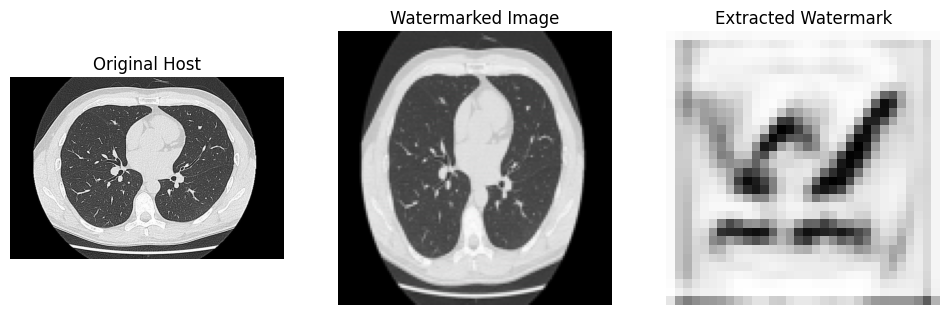

In [ ]:
# ===================== INSTALL =====================
!pip install pytorch_wavelets pytorch-msssim --quiet

# ===================== IMPORTS =====================
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
from PIL import Image
from pytorch_wavelets import DWTForward, DWTInverse
from pytorch_msssim import ssim
from google.colab import files
import matplotlib.pyplot as plt

# ===================== DEVICE =====================
device = "cuda" if torch.cuda.is_available() else "cpu"

# ===================== UPLOAD IMAGES =====================
print("📤 Upload HOST image")
uploaded_host = files.upload()
host_path = list(uploaded_host.keys())[0]

print("📤 Upload WATERMARK image")
uploaded_wm = files.upload()
wm_path = list(uploaded_wm.keys())[0]

# ===================== TRANSFORMS =====================
host_tf = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

wm_tf = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

# ===================== MODELS =====================
class Embedder(nn.Module):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.alpha = alpha
        self.dwt  = DWTForward(J=1, wave='haar')
        self.idwt = DWTInverse(wave='haar')

        self.wm_enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, 1, 1), nn.ReLU()
        )

        self.fuse = nn.Sequential(
            nn.Conv2d(32+3, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 3, 3, 1, 1)
        )

    def forward(self, host, wm):
        Yl, Yh = self.dwt(host)
        LH = Yh[0][:,:,0]

        wm_f = self.wm_enc(wm)
        wm_f = nn.functional.interpolate(wm_f, size=LH.shape[-2:])

        delta = self.fuse(torch.cat([LH, wm_f], 1))
        fused = LH + self.alpha * delta

        Yh_new = torch.stack([fused, Yh[0][:,:,1], Yh[0][:,:,2]], 2)
        out = self.idwt((Yl, [Yh_new]))

        return torch.clamp(out, 0, 1)

class Extractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.dwt = DWTForward(J=1, wave='haar')

        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 32, 3, 1, 1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((32,32)),
            nn.Conv2d(32, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, wimg, host):
        _, Yh_w = self.dwt(wimg)
        _, Yh_h = self.dwt(host)
        residual = Yh_w[0][:,:,0] - Yh_h[0][:,:,0]
        return self.net(residual)

# ===================== LOAD MODELS =====================
E = Embedder().to(device)
X = Extractor().to(device)

E.load_state_dict(torch.load("embedder.pth", map_location=device))
X.load_state_dict(torch.load("extractor.pth", map_location=device))

E.eval()
X.eval()

# ===================== LOAD TEST IMAGES =====================
host_img = Image.open(host_path).convert("RGB")
wm_img   = Image.open(wm_path)

host = host_tf(host_img).unsqueeze(0).to(device)
wm   = wm_tf(wm_img).unsqueeze(0).to(device)

# ===================== EMBED & EXTRACT =====================
with torch.no_grad():
    watermarked = E(host, wm)
    extracted_wm = X(watermarked, host)

# ===================== METRICS =====================
def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 10 * torch.log10(1.0 / mse)

def nc(wm, wm_hat):
    wm, wm_hat = wm.flatten(), wm_hat.flatten()
    return torch.sum(wm * wm_hat) / torch.sqrt(
        torch.sum(wm**2) * torch.sum(wm_hat**2) + 1e-8
    )

psnr_val = psnr(watermarked, host).item()
ssim_val = ssim(watermarked, host, data_range=1).item()
nc_val   = nc(wm, extracted_wm).item()

print(f"\n📊 RESULTS")
print(f"PSNR : {psnr_val:.2f} dB")
print(f"SSIM : {ssim_val:.4f}")
print(f"NC   : {nc_val:.4f}")

# ===================== SAVE OUTPUTS =====================
def save_tensor(t, path):
    t = t.squeeze(0).cpu().permute(1,2,0).numpy()
    t = (t * 255).astype(np.uint8)
    Image.fromarray(t).save(path)

save_tensor(watermarked, "watermarked_output.png")

wm_out = extracted_wm.squeeze().cpu().numpy()
wm_out = (wm_out * 255).astype(np.uint8)
Image.fromarray(wm_out).save("extracted_watermark.png")

files.download("watermarked_output.png")
files.download("extracted_watermark.png")

# ===================== DISPLAY =====================
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Original Host")
plt.imshow(host_img)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Watermarked Image")
plt.imshow(Image.open("watermarked_output.png"))
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Extracted Watermark")
plt.imshow(Image.open("extracted_watermark.png"), cmap="gray")
plt.axis("off")

plt.show()


In [ ]:
# ===================== INSTALL =====================
!pip install pytorch_wavelets pytorch-msssim --quiet

# ===================== IMPORTS =====================
import os, torch, random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pytorch_wavelets import DWTForward, DWTInverse
from pytorch_msssim import ssim

# ===================== DATASET =====================
class WatermarkDataset(Dataset):
    def __init__(self, host_dir, wm_dir):
        self.hosts = [os.path.join(host_dir,f) for f in os.listdir(host_dir)]
        self.wm_path = os.path.join(wm_dir, os.listdir(wm_dir)[0])

        self.ht = transforms.Compose([
            transforms.Resize((128,128)),
            transforms.ToTensor()
        ])
        self.wt = transforms.Compose([
            transforms.Resize((32,32)),
            transforms.Grayscale(),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.hosts)

    def __getitem__(self, i):
        host = Image.open(self.hosts[i]).convert("RGB")
        wm   = Image.open(self.wm_path)
        wm   = (self.wt(wm) > 0.5).float()   # IMPORTANT
        return self.ht(host), wm

# ===================== EMBEDDER =====================
class Embedder(nn.Module):
    def __init__(self, alpha=0.15):
        super().__init__()
        self.alpha = alpha
        self.dwt = DWTForward(J=1, wave='haar')
        self.idwt = DWTInverse(wave='haar')

        self.wm_enc = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU()
        )

        self.fuse = nn.Sequential(
            nn.Conv2d(64+3, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 3, 1)
        )

    def forward(self, host, wm):
        Yl, Yh = self.dwt(host)
        LH = Yh[0][:,:,0]

        wm_f = self.wm_enc(wm)
        wm_f = nn.functional.interpolate(wm_f, size=LH.shape[-2:])

        delta = self.fuse(torch.cat([LH, wm_f], 1))
        fused = LH + self.alpha * delta

        Yh_new = torch.stack([fused, Yh[0][:,:,1], Yh[0][:,:,2]], 2)
        out = self.idwt((Yl, [Yh_new]))

        return torch.clamp(out, 0, 1), delta

# ===================== BLIND EXTRACTOR =====================
class Extractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.dwt = DWTForward(J=1, wave='haar')

        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 32, 3, 1, 1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((32,32)),
            nn.Conv2d(32, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        _, Yh = self.dwt(img)
        return self.net(Yh[0][:,:,0])

# ===================== ATTACK =====================
def attack(x):
    if random.random() < 0.5:
        x = x + 0.01 * torch.randn_like(x)
    return torch.clamp(x, 0, 1)

# ===================== METRICS =====================
def psnr(x, y):
    mse = torch.mean((x - y) ** 2)
    return 10 * torch.log10(1.0 / mse)

def nc(a, b):
    a, b = a.flatten(), b.flatten()
    return torch.sum(a*b) / (torch.sqrt(torch.sum(a*a)*torch.sum(b*b)) + 1e-8)

# ===================== TRAINING =====================
device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = WatermarkDataset("data/host", "data/watermark")
loader = DataLoader(dataset, batch_size=8, shuffle=True)

E = Embedder().to(device)
X = Extractor().to(device)

opt = optim.Adam(
    list(E.parameters()) + list(X.parameters()),
    lr=1e-4
)

EPOCHS = 80

for epoch in range(EPOCHS):
    P = S = N = 0
    c = 0

    for host, wm in loader:
        host, wm = host.to(device), wm.to(device)

        wimg, _ = E(host, wm)
        wimg_a = attack(wimg)
        wm_hat = X(wimg_a)

        L_img  = nn.functional.mse_loss(wimg, host)
        L_wm   = nn.functional.mse_loss(wm_hat, wm)
        L_ssim = 1 - ssim(wimg, host, data_range=1)

        loss = L_img + 5*L_wm + 0.2*L_ssim

        opt.zero_grad()
        loss.backward()
        opt.step()

        with torch.no_grad():
            P += psnr(wimg, host)
            S += ssim(wimg, host, data_range=1)
            N += nc(wm, wm_hat)
            c += 1

    print(
        f"Epoch {epoch+1:03d} | "
        f"PSNR {P/c:.2f} | "
        f"SSIM {S/c:.4f} | "
        f"NC {N/c:.4f}"
    )

# ===================== SAVE =====================
torch.save(E.state_dict(), "embedder.pth")
torch.save(X.state_dict(), "extractor.pth")

print("✅ FULLY FIXED TRAINING COMPLETE")


Epoch 001 | PSNR 55.51 | SSIM 0.9983 | NC 0.9180
Epoch 002 | PSNR 55.51 | SSIM 0.9983 | NC 0.9178
Epoch 003 | PSNR 55.51 | SSIM 0.9983 | NC 0.9183
Epoch 004 | PSNR 55.51 | SSIM 0.9983 | NC 0.9192
Epoch 005 | PSNR 55.51 | SSIM 0.9983 | NC 0.9209
Epoch 006 | PSNR 55.51 | SSIM 0.9983 | NC 0.9254
Epoch 007 | PSNR 55.51 | SSIM 0.9983 | NC 0.9327
Epoch 008 | PSNR 55.51 | SSIM 0.9983 | NC 0.9385
Epoch 009 | PSNR 55.51 | SSIM 0.9983 | NC 0.9422
Epoch 010 | PSNR 55.51 | SSIM 0.9983 | NC 0.9448
Epoch 011 | PSNR 55.51 | SSIM 0.9983 | NC 0.9460
Epoch 012 | PSNR 55.51 | SSIM 0.9983 | NC 0.9497
Epoch 013 | PSNR 55.51 | SSIM 0.9983 | NC 0.9483
Epoch 014 | PSNR 55.51 | SSIM 0.9983 | NC 0.9504
Epoch 015 | PSNR 55.51 | SSIM 0.9983 | NC 0.9507
Epoch 016 | PSNR 55.51 | SSIM 0.9983 | NC 0.9514
Epoch 017 | PSNR 55.51 | SSIM 0.9983 | NC 0.9478
Epoch 018 | PSNR 55.51 | SSIM 0.9983 | NC 0.9501
Epoch 019 | PSNR 55.51 | SSIM 0.9983 | NC 0.9492
Epoch 020 | PSNR 55.51 | SSIM 0.9983 | NC 0.9528
Epoch 021 | PSNR 55.

In [ ]:
# ===================== INSTALL =====================
!pip install pytorch_wavelets pytorch-msssim --quiet

# ===================== IMPORTS =====================
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
from PIL import Image
from pytorch_wavelets import DWTForward, DWTInverse
from pytorch_msssim import ssim
from google.colab import files
import matplotlib.pyplot as plt

# ===================== DEVICE =====================
device = "cuda" if torch.cuda.is_available() else "cpu"

# ===================== UPLOAD IMAGES =====================
print("📤 Upload HOST image")
host_file = list(files.upload().keys())[0]

print("📤 Upload WATERMARK image")
wm_file = list(files.upload().keys())[0]

# ===================== TRANSFORMS =====================
host_tf = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

wm_tf = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

# ===================== MODELS =====================
class Embedder(nn.Module):
    def __init__(self, alpha=0.15):
        super().__init__()
        self.alpha = alpha
        self.dwt = DWTForward(J=1, wave='haar')
        self.idwt = DWTInverse(wave='haar')

        self.wm_enc = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU()
        )

        self.fuse = nn.Sequential(
            nn.Conv2d(64+3, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 3, 1)
        )

    def forward(self, host, wm):
        Yl, Yh = self.dwt(host)
        LH = Yh[0][:,:,0]

        wm_f = self.wm_enc(wm)
        wm_f = nn.functional.interpolate(wm_f, size=LH.shape[-2:])

        delta = self.fuse(torch.cat([LH, wm_f], 1))
        fused = LH + self.alpha * delta

        Yh_new = torch.stack([fused, Yh[0][:,:,1], Yh[0][:,:,2]], 2)
        out = self.idwt((Yl, [Yh_new]))

        return torch.clamp(out, 0, 1)

class Extractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.dwt = DWTForward(J=1, wave='haar')

        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 32, 3, 1, 1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((32,32)),
            nn.Conv2d(32, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        _, Yh = self.dwt(img)
        return self.net(Yh[0][:,:,0])

# ===================== LOAD MODELS =====================
E = Embedder().to(device)
X = Extractor().to(device)

E.load_state_dict(torch.load("embedder.pth", map_location=device))
X.load_state_dict(torch.load("extractor.pth", map_location=device))

E.eval()
X.eval()

# ===================== LOAD IMAGES =====================
host_img = Image.open(host_file).convert("RGB")
wm_img   = Image.open(wm_file).convert("L")

host = host_tf(host_img).unsqueeze(0).to(device)
wm   = wm_tf(wm_img).unsqueeze(0).to(device)

# binarize watermark (IMPORTANT)
wm = (wm > 0.5).float()

# ===================== ATTACK (MATCH TRAINING) =====================
def attack(img):
    img = img + 0.01 * torch.randn_like(img)
    return torch.clamp(img, 0, 1)

# ===================== EMBED & EXTRACT =====================
with torch.no_grad():
    watermarked = E(host, wm)
    attacked    = attack(watermarked)
    extracted   = X(attacked)

# binarize extracted watermark
extracted_bin = (extracted > 0.5).float()

# ===================== METRICS =====================
def psnr(x, y):
    mse = torch.mean((x - y) ** 2)
    return 10 * torch.log10(1.0 / mse)

def nc(a, b):
    a, b = a.flatten(), b.flatten()
    return torch.sum(a*b) / (torch.sqrt(torch.sum(a*a)*torch.sum(b*b)) + 1e-8)

psnr_val = psnr(watermarked, host).item()
ssim_val = ssim(watermarked, host, data_range=1).item()
nc_val   = nc(wm, extracted_bin).item()

print("\n📊 RESULTS")
print(f"PSNR : {psnr_val:.2f} dB")
print(f"SSIM : {ssim_val:.4f}")
print(f"NC   : {nc_val:.4f}")

# ===================== SAVE OUTPUTS =====================
def save_rgb(tensor, path):
    img = tensor.detach().cpu().squeeze(0)
    img = np.transpose(img.numpy(), (1,2,0))
    img = (img * 255).astype(np.uint8)
    Image.fromarray(img).save(path)

def save_gray(tensor, path):
    img = tensor.detach().cpu().squeeze(0).squeeze(0)
    img = (img.numpy() * 255).astype(np.uint8)
    Image.fromarray(img, mode="L").save(path)

save_rgb(watermarked, "watermarked.png")
save_gray(extracted_bin, "extracted_watermark.png")

files.download("watermarked.png")
files.download("extracted_watermark.png")

# ===================== DISPLAY =====================
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Original Host")
plt.imshow(host_img)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Watermarked Image")
plt.imshow(Image.open("watermarked.png"))
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Extracted Watermark")
plt.imshow(Image.open("extracted_watermark.png"), cmap="gray")
plt.axis("off")

plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 2.7 MB/s eta 0:00:00
📤 Upload HOST image


KeyboardInterrupt: 